In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nuance.utils import periodic_transit, tv_dv
import numpy as np
import tinygp
import jax
jax.config.update("jax_enable_x64", True)

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Dataset

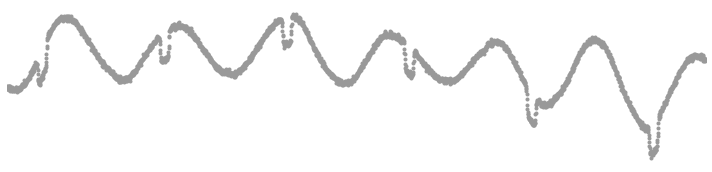

In [2]:
dt = 2/60/24
time = np.arange(0, 4, dt)
error = np.ones_like(time)*0.001
X = np.vander(time, N=4, increasing=True)
w = [1., 5e-4, -2e-4, -5e-4]
true_period = 0.7
duration, depth = 0.05, 0.02
t0 = 0.2
true_transit = depth*periodic_transit(time, t0, duration, P=true_period)
mean = (true_transit + X@w)

kernel = tinygp.kernels.quasisep.SHO(np.pi/(6*duration), 45., depth)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean_value=mean)
diff_flux = gp.sample(jax.random.PRNGKey(40))
vari = diff_flux - mean

plt.figure(None, (10, 2.5))
plt.plot(time, diff_flux, ".", c="0.6")
plt.xlabel("time (days)")
plt.ylabel("diff. flux")
plt.xlim(time.min(), time.max())
#plt.title("example dataset", loc="left")
plt.axis("off")
plt.tight_layout()

#plt.savefig("../figures/principle_dataset.pdf")

(0.0, 0.0, 0.0)
(0.5, 0.5, 0.5)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


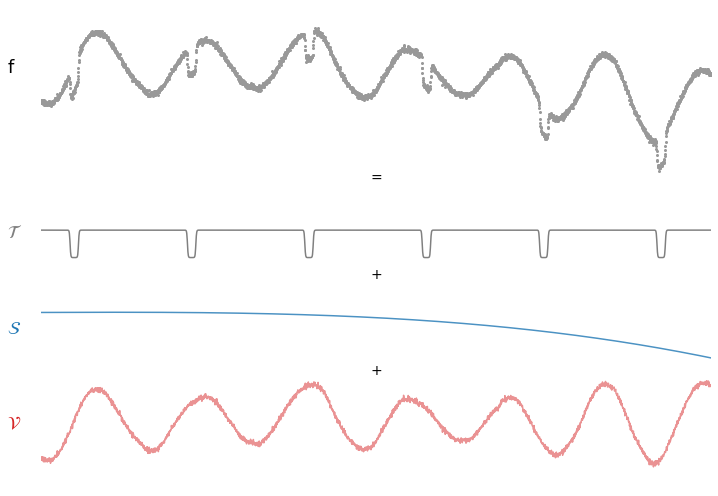

In [9]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(10., 7.))
ax= plt.subplot(1,1,1)
h = 0.07
ax.plot(time, diff_flux + 0.05, ".", c="0.6", ms=4)
ax.plot(time, true_transit + 1. - h, c="0.5")
ax.plot(time,  X@w - 2*h + 0.01, c="C0", alpha=0.8)
ax.plot(time,  vari + 1. - 3*h, c="C3", alpha=0.5)
ax.axis("off")
ax.set_xlim(time.min(), time.max())
ax.axis("off")
ax.set_ylabel("diff. flux")
ax.set_xlabel("time (days)")
ax.text(time.mean(), 1. - (0 + .5)*h, "=", ha='center', fontsize=14)
[ax.text(time.mean(), 1. - (i + .5)*h, "+", ha='center', fontsize=14) for i in [1, 2]]
for text, color, y in zip(
    ["f", "$\mathcal{T}$", "$\mathcal{S}$", "$\mathcal{V}$"], 
    ["k", "0.5", "C0", "C3"],
    [1 + 0.05, 1. - h, 1. - 2*h, 1. - 3*h]):
    
    ax.text(-0.2, y - 0.005, text, ha='left', fontsize=18, color=color)
    print(mcolors.to_rgb(color))

plt.tight_layout()
plt.savefig("../figures/principle_dataset_decomposed.pdf")

# Linear Search

In [3]:
from nuance import Nuance

nu = Nuance(time, diff_flux, error, kernel, X.T)

t0s = time.copy()
Ds = np.linspace(0.0001, 0.1, 30)
nu.linear_search(t0s, Ds)

  0%|          | 0/2880 [00:00<?, ?it/s]

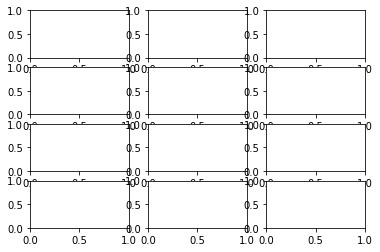

In [18]:
fig, axes = plt.subplots(4, 3)

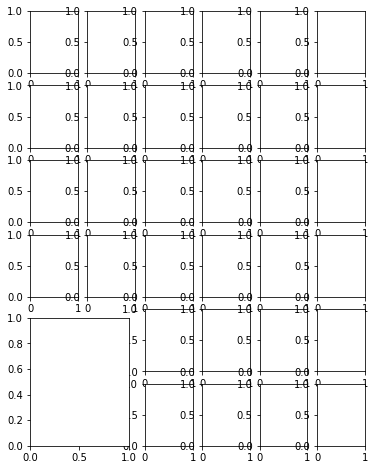

In [25]:
plt.subplots(6, 6, figsize=(6., 8))
ax4 = plt.subplot2grid((3, 3), (2, 0))

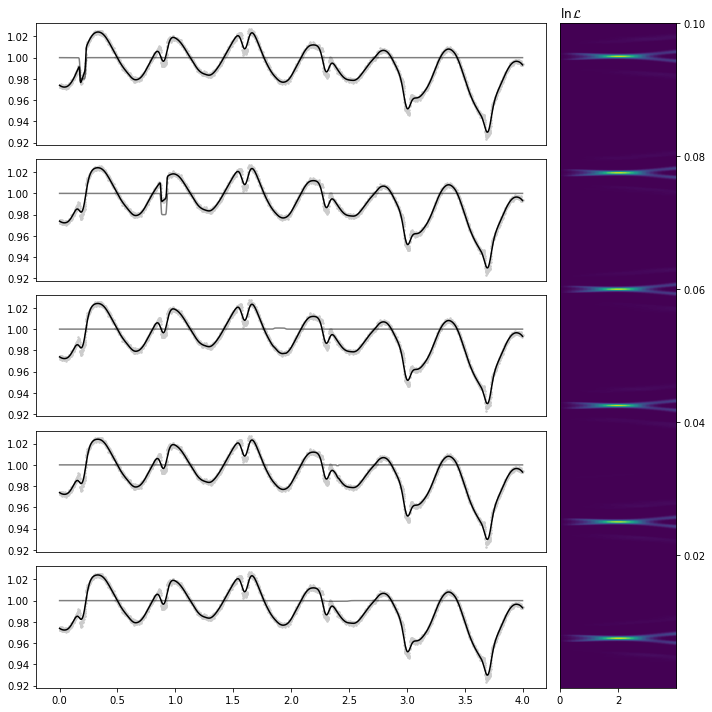

In [120]:
plt.figure(figsize=(10, 10))

w = 5
h = 5

t0s = [t0, t0 + true_period, t0 + 2*true_period + 0.3, t0 + 3*true_period + 0.1, t0 + 3*true_period + 0.1]
ds = [duration, duration, 2*duration, 0.4*duration, 4*duration]
for i, _t0 in enumerate(t0s):
    ax = plt.subplot(w, h, (w*i+1, w*(i+1)-1))
    ax.plot(time, diff_flux, ".", c="0.8", ms=3)
    if i != w-1:
        ax.xaxis.set_ticks([], [])
    m = nu.models(_t0, ds[i])
    ax.plot(time, np.sum(m, 0), c="k")
    ax.plot(time, m[1]+1., c="k", alpha=0.5)

ax = plt.subplot(w,h,(w, h*w))
extent = nu.search_data.t0s.min(), nu.search_data.t0s.max(), nu.search_data.Ds.min(), nu.search_data.Ds.max()
ax.imshow(nu.search_data.ll, aspect='auto', extent=extent)
ax.set_title("$\mathcal{\ln L}$", loc='left')
ax.yaxis.tick_right()


plt.tight_layout()

#plt.ylabel("$D$\nDuration (days)")
#plt.xlabel("Epoch (days)\n$T$")
#plt.tight_layout()

In [104]:
np.sum(nu.models(_t0, ds[i]), 0)

array([0.97394357, 0.97382987, 0.97372064, ..., 0.99358902, 0.99340704,
       0.99321964])

In [75]:
w

5

# Periodic search

In [196]:
periods = np.linspace(0.1, 3, 5000)
search = nu.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

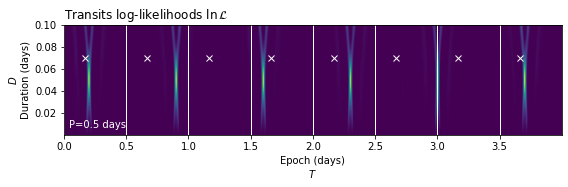

In [293]:
plt.figure(None, (8., 2.7))

periods = [0.35, 0.5, 0.7, 0.9]
P1 = periods[1]
fold = nu.search_data.fold_ll
pt0s, Pv, Pc = fold(P1)
extent = 0, 1, nu.search_data.Ds.min(), nu.search_data.Ds.max()
k = len(pt0s)//3

nu.search_data.show_ll()
plt.xlim(nu.time.min(), nu.time.max())
plt.ylabel("$D$\nDuration (days)")
plt.xlabel("Epoch (days)\n$T$")
plt.title("Transits log-likelihoods $\ln\mathcal{L}$", loc="left")

for i in range(int(np.ceil((nu.time.max() -  nu.time.min())/P1))):
    plt.axvline(i*P1, c="w", lw=1)
    plt.plot((i + pt0s[k])*P1, 0.07, "x", c="w")

plt.text(0.01, 0.05, f"P={P1} days", fontsize=10, c="w", ha='left', va='bottom', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig("../figures/principle_periodic_0.pdf")

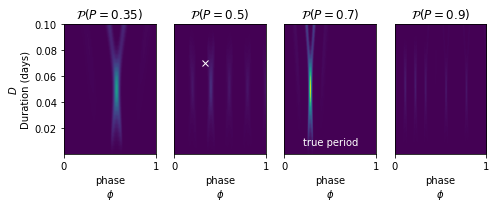

In [294]:
plt.figure(None, (7., 3.))

n = len(periods)

Pc = fold(true_period)[2]
Pc -= np.median(Pc)
M = np.max(Pc)

for i, P in enumerate(periods):
    fold = nu.search_data.fold_ll
    pt0s, Pv, Pc = fold(P)
    
    ax = plt.subplot(1, n, i+1)
    if i == 0:
        plt.ylabel("$D$\nDuration (days)")
        
    Pc -= np.median(Pc)
    plt.imshow(Pc.T, aspect='auto', extent=extent, origin="lower", vmin=np.median(Pc), vmax=M)
    plt.xlabel("phase\n$\phi$")
    plt.title(rf"$\mathcal{{P}}(P={{{P}}})$")
    
    if P==true_period:
        plt.text(0.5, 0.05, f"true period", fontsize=10, c="w", ha='center', va='bottom', transform=plt.gca().transAxes)
        
    if P==P1:
        plt.plot(pt0s[k], 0.07, "x", c="w")

    plt.tick_params(
        axis='y',       
        which='both',
        left=i==0,      
        labelleft=i==0)
    ax.set_xticks([0, 1], ["0", "1"])

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("../figures/principle_periodic_1.pdf")

# Periodogram

In [291]:
P = true_period
phases, _, Pc = fold(P)

i, j = np.unravel_index(np.argmax(Pc), Pc.shape)
_phi, _D = phases[i], nu.search_data.Ds[j]
_t0 = _phi*P

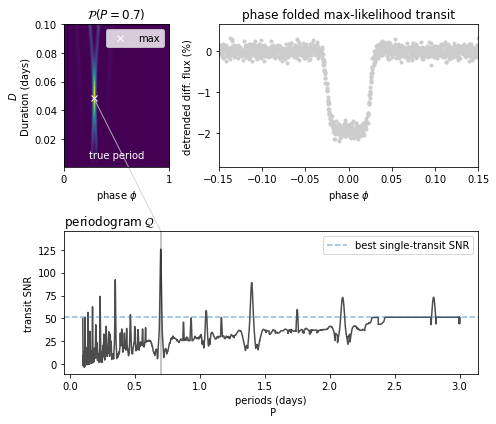

In [292]:
from nuance.utils import phase, binn
from matplotlib.patches import ConnectionPatch

plt.figure(None, (7., 6.))

ax0 = plt.subplot(2, 3, 1)
plt.imshow(Pc.T, aspect='auto', extent=extent, origin="lower")
plt.xlabel("phase $\phi$")
plt.ylabel("$D$\nDuration (days)")
plt.plot(_phi, _D, "x", c="w", label="max")
plt.title(f"$\mathcal{{P}}(P={{{P}}})$")
ax0.set_xticks([0, 1], ["0", "1"])
ax0.text(0.5, 0.05, f"true period", fontsize=10, c="w", ha='center', va='bottom', transform=ax0.transAxes)
plt.legend()

ax = plt.subplot(2, 3, (2, 3))
mean, astro, noise = nu.models(_t0, _D, P)
phi = phase(nu.time, _t0, P)
detrended = (nu.flux - noise - mean)*100 # percent
plt.plot(phi, detrended, ".", c=".8")
plt.xlim(*(np.array([-1, 1])*3*duration))
_depth = float(np.abs(detrended.min()))
plt.ylim(*(np.array([-1, 1])*_depth*0.8 - _depth/2))
plt.xlabel("phase $\phi$")
ax.set_title(f"phase folded max-likelihood transit")
plt.ylabel("detrended diff. flux (%)")

ax_per = plt.subplot(2, 3, (4,6))
ax_per.plot(search.periods, search.Q_snr, c="0.3")
ax_per.set_title("periodogram $\mathcal{Q}$", loc="left")
ax_per.set_xlabel("periods (days)\n P")
ax_per.set_ylabel("transit SNR")
ax_per.axvline(true_period, c="k", alpha=0.3)
ylim = np.array(ax_per.get_ylim())
ax_per.set_ylim(*(ylim*1.1))
con = ConnectionPatch(xyA=(_phi, _D), xyB=(P, ax_per.get_ylim()[1]), coordsA="data", coordsB="data", axesA=ax0, axesB=ax_per, color="0.8", alpha=0.8)
ax0.add_artist(con)
snr_0 = float(nu.snr(_t0, _D, 1000))
plt.axhline(snr_0, alpha=0.5, ls="--", label="best single-transit SNR")
plt.legend()
#ax_per.text(2.5, 40, f"best non-periodic\ntransit SNR", fontsize=10, c="C0", alpha=0.8, ha='center', va='top')


plt.tight_layout()
plt.savefig("../figures/principle_Q.pdf")

In [279]:
snr_0 = float(nu.snr(_t0, _D, 1000))

51.18065156693503

In [223]:
detrended.min()

DeviceArray(-0.02193351, dtype=float64)

In [ ]:
c="k"
alpha = .15
for i in range(int(np.ceil((nu.time.max() -  nu.time.min())/P))):
    ax0.axvline(i*P, c="w", lw=1)
    con = ConnectionPatch(xyA=(1., 1.), xyB=(i*P, 0.), coordsA="axes fraction", coordsB="data", axesA=ax2, axesB=ax0, color=c, zorder=-1, alpha=alpha)
    ax.add_artist(con)
    con = ConnectionPatch(xyA=(0., 1.), xyB=(i*P, 0.), coordsA="axes fraction", coordsB="data", axesA=ax2, axesB=ax0, color=c, zorder=-1, alpha=alpha)
    ax.add_artist(con)

ax0.set_title(f"P={P} days likelihood folds", loc="left", zorder=10)
ax.set_zorder(2)
ax0.set_zorder(1)

ax_per = plt.subplot(3, 2, (7, 9))
ax_per.plot(*search.periodogram(), c="0.3")
ax_per.set_title("periodogram", loc="left")
ax_per.set_xlabel("periods (days)\n P")
ax_per.set_ylabel("transit SNR")
ax_per.axvline(true_period, c="k", alpha=0.3)
ylim = np.array(ax_per.get_ylim())
ax_per.set_ylim(*(ylim*1.1))
con = ConnectionPatch(xyA=(t0, duration), xyB=(true_period, ax_per.get_ylim()[1]), coordsA="data", coordsB="data", axesA=ax2, axesB=ax_per, color="0.8", alpha=0.8)
ax.add_artist(con)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.35)
#plt.savefig("../figures/principle_Q.pdf")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot it
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
a0.plot(x, y)
a1.plot(y, x)

f.tight_layout()
f.savefig('grid_figure.pdf')